# 🚀 Mastering SMOTE Techniques for Imbalanced Datasets

## 🎯 What You'll Learn Today
- How to handle imbalanced datasets like a pro
- 5 different SMOTE techniques and when to use them
- Real-world application on diabetes prediction
- Performance comparison between different approaches

### 🤔 Why Does This Matter?
Imagine you're building a medical AI system:
- **99% patients are healthy** (majority class)
- **1% patients have a rare disease** (minority class)

A naive model might just predict "healthy" for everyone and get 99% accuracy - but miss all the sick patients! 😱

**SMOTE techniques solve this by creating synthetic minority samples to balance your dataset!**

## 📊 Step 1: Loading Our Dataset

We're using the **Pima Indians Diabetes Dataset** - a classic machine learning dataset where we predict if someone has diabetes based on medical measurements.

### 🔍 What We're Looking For:
- **Dataset size** and **feature count**
- **Class distribution** (how imbalanced is it?)
- **Missing values** (data quality check)

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data_imbalance/diabetes.csv')
print('shape:', df.shape)
print('columns:', df.columns.tolist())
print('class counts:', df['Outcome'].value_counts().to_dict())
print('class distribution:', df['Outcome'].value_counts(normalize=True).to_dict())

shape: (768, 9)
columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
class counts: {0: 500, 1: 268}
class distribution: {0: 0.6510416666666666, 1: 0.3489583333333333}


In [24]:
df.head()

print("\nDataset Info:")
print(f"Total samples: {len(df)}")
print(f"Features: {len(df.columns)-1}")
print(f"Target variable: Outcome (0=No Diabetes, 1=Diabetes)")
print(f"Missing values: {df.isnull().sum().sum()}")

# Check class imbalance
print(f"\nClass distribution:")
print(df['Outcome'].value_counts())
print(f"Imbalance ratio: {df['Outcome'].value_counts()[0]/df['Outcome'].value_counts()[1]:.2f}:1")


Dataset Info:
Total samples: 768
Features: 8
Target variable: Outcome (0=No Diabetes, 1=Diabetes)
Missing values: 0

Class distribution:
Outcome
0    500
1    268
Name: count, dtype: int64
Imbalance ratio: 1.87:1


### 🔎 Dataset Overview
Let's explore our data and understand the imbalance problem:

                             mean      std
Pregnancies                 3.845    3.370
Glucose                   120.895   31.973
BloodPressure              69.105   19.356
SkinThickness              20.536   15.952
Insulin                    79.799  115.244
BMI                        31.993    7.884
DiabetesPedigreeFunction    0.472    0.331
Age                        33.241   11.760
Outcome                     0.349    0.477


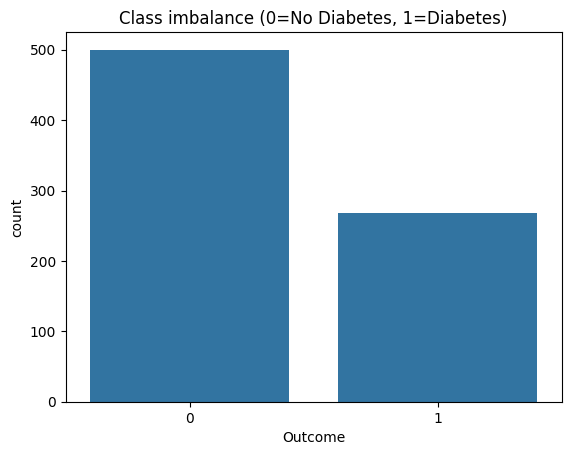

Train distribution: Counter({0: 400, 1: 214})
Test distribution: Counter({0: 100, 1: 54})


In [25]:
print(df.describe().T[['mean','std']].round(3))
sns.countplot(x='Outcome', data=df)
plt.title('Class imbalance (0=No Diabetes, 1=Diabetes)')
plt.show()

# Prepare features and target
X = df.drop(['Outcome'], axis=1).copy()
y = df['Outcome'].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,
                                                    stratify=y, random_state=42)
print('Train distribution:', Counter(y_train))
print('Test distribution:',  Counter(y_test))

## 📈 Step 2: Data Preprocessing & Visualization

Now let's prepare our data for machine learning and visualize the class imbalance:

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, average_precision_score

clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print('PR-AUC (avg precision):', average_precision_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.82      0.75      0.79       100
           1       0.60      0.70      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154

PR-AUC (avg precision): 0.6959740804188068


## 🎯 Step 3: Baseline Model (Without SMOTE)

Let's first see how a regular model performs on our imbalanced dataset. We'll use **Logistic Regression** with balanced class weights as our baseline:

### 💡 Key Metrics to Watch:
- **Precision**: How many predicted diabetes cases are actually diabetes?
- **Recall**: How many actual diabetes cases did we catch?
- **F1-Score**: Harmonic mean of precision and recall
- **PR-AUC**: Area under Precision-Recall curve (great for imbalanced data!)

In [27]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(pipe, X_scaled, y, cv=cv, scoring=make_scorer(f1_score), n_jobs=-1)
print('CV F1 scores (SMOTE+RF):', scores, 'mean:', np.mean(scores))

CV F1 scores (SMOTE+RF): [0.63063063 0.64150943 0.67256637 0.70909091 0.61386139] mean: 0.6535317463007668


## 🔄 Step 4: Regular SMOTE + Random Forest

Now let's try the **classic SMOTE technique**! 

### 🧠 How SMOTE Works:
1. **Find minority samples** (diabetes patients)
2. **Locate their nearest neighbors** (similar patients)
3. **Create synthetic samples** by interpolating between them
4. **Balance the dataset** for better learning

We'll use **cross-validation** to get robust performance estimates!

In [28]:
from imblearn.over_sampling import SVMSMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Using SVM-SMOTE for generating synthetic samples
svm_smote = SVMSMOTE(random_state=42)
pipe2 = Pipeline([
    ('svm_smote', svm_smote),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1))
])
pipe2.fit(X_train, y_train)
y_pred2 = pipe2.predict(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       100
           1       0.58      0.70      0.64        54

    accuracy                           0.72       154
   macro avg       0.70      0.72      0.71       154
weighted avg       0.74      0.72      0.73       154



## 🎪 Step 5: SVM-SMOTE (Smart Boundary Focus)

**SVM-SMOTE** is like having a smart teacher who focuses on the hardest problems!

### 🚀 The SVM-SMOTE Advantage:
- **Uses Support Vector Machine** to find the decision boundary
- **Generates samples near the boundary** where they're most needed
- **Smarter than regular SMOTE** - no wasted effort on easy regions
- **Perfect for complex datasets** like medical diagnosis

Think of it as "precision sampling" vs "random sampling"!

In [29]:
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score

adasyn = ADASYN(random_state=42)
pipe_adasyn = Pipeline([('adasyn', adasyn),
                        ('clf', RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1))])
pipe_adasyn.fit(X_train, y_train)
probs_adasyn = pipe_adasyn.predict_proba(X_test)[:,1]
print('ADASYN PR-AUC:', average_precision_score(y_test, probs_adasyn))

ADASYN PR-AUC: 0.6780561636745202


## 🎯 Step 6: ADASYN (Adaptive Synthetic Sampling)

**ADASYN** is the "adaptive genius" of sampling techniques!

### 🧩 Why ADASYN is Special:
- **Adapts to difficulty** - creates more samples where it's harder to classify
- **Smart resource allocation** - focuses effort where it matters most
- **Like a personal tutor** - spends more time with struggling students
- **Density-aware** - considers how crowded each region is

Perfect for datasets where some regions are naturally harder to classify!

In [30]:
smotetomek = SMOTETomek(random_state=42)
pipe_smote_tomek = Pipeline([('smote_tomek', smotetomek),
                             ('clf', RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1))])
pipe_smote_tomek.fit(X_train, y_train)
print('SMOTE+Tomek PR-AUC:', average_precision_score(y_test, pipe_smote_tomek.predict_proba(X_test)[:,1]))

SMOTE+Tomek PR-AUC: 0.7057889561887374


## 🧹 Step 7: SMOTE + Tomek Links (Balance + Clean)

**SMOTETomek** is the "best of both worlds" approach!

### 🔄 Two-Step Process:
1. **SMOTE**: Generate synthetic samples to balance classes
2. **Tomek Links**: Remove problematic boundary samples for cleaner separation

### 🎯 What are Tomek Links?
Imagine students sitting in wrong classroom sections - **Tomek Links** finds and removes these "confused" data points that create noise at class boundaries.

**Result**: Balanced AND clean dataset for optimal learning!

In [37]:
try:
    from imblearn.over_sampling import KMeansSMOTE
    km_smote = KMeansSMOTE(random_state=42)
    X_km, y_km = km_smote.fit_resample(X_train, y_train)
    print('KMeansSMOTE resampled counts:', Counter(y_km))
except Exception as e:
    print('KMeansSMOTE not available. Fallback: manual cluster-then-SMOTE strategy.')

    from sklearn.cluster import KMeans
    from imblearn.over_sampling import SMOTE

    # Get minority class samples (diabetes positive cases)
    X_train_minority = X_train[y_train==1]
    k = min(4, len(X_train_minority))  # Ensure we don't have more clusters than samples
    if len(X_train_minority) >= k:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_minority)
        res_X_parts = []
        res_y_parts = []
        for cluster_id in range(k):
            cluster_idx = np.where(kmeans.labels_ == cluster_id)[0]
            Xc = X_train_minority[cluster_idx]
            if len(Xc) < 2:
                res_X_parts.append(Xc)
                res_y_parts.append(np.ones(len(Xc)))
                continue
            sm = SMOTE(random_state=42, k_neighbors=min(1, len(Xc)-1))
            Xc_res, yc_res = sm.fit_resample(Xc, np.ones(len(Xc)))
            res_X_parts.append(Xc_res)
            res_y_parts.append(yc_res)
        X_aug = np.vstack(res_X_parts)
        y_aug = np.concatenate(res_y_parts)
        print('Manual cluster-based minority samples after augmentation:', len(y_aug))
    else:
        print('Not enough minority samples for clustering approach.')

KMeansSMOTE resampled counts: Counter({0: 400, 1: 400})


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


## 🎪 Step 8: K-Means SMOTE (Cluster-Based Sampling)

**K-Means SMOTE** combines clustering with synthetic sampling!

### 🔍 The Strategy:
1. **Group similar minority samples** using K-Means clustering
2. **Apply SMOTE within each cluster** for targeted generation
3. **Preserve local patterns** while creating diversity

### 💡 Why This Works:
- **Respects data structure** - doesn't mix different patient types
- **Targeted sampling** - creates samples that make sense within each group
- **Handles complex distributions** better than one-size-fits-all approaches

If K-Means SMOTE isn't available, we'll implement a custom cluster-then-SMOTE strategy!

In [32]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report

brf = BalancedRandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1)
brf.fit(X_train, y_train)
y_pred_brf = brf.predict(X_test)
print('Balanced RF report:')
print(classification_report(y_test, y_pred_brf))

Balanced RF report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       100
           1       0.60      0.72      0.66        54

    accuracy                           0.73       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



## 🌳 Step 9: Balanced Random Forest (Built-in Solution)

**Balanced Random Forest** handles imbalance automatically!

### 🚀 How It Works:
- **Each tree** sees a balanced subset of data
- **Bootstrap sampling** ensures fair representation
- **No manual SMOTE needed** - balance is built into the algorithm
- **Ensemble power** combines multiple balanced trees

Think of it as having a team of experts, each trained on balanced data!

In [33]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.tree import DecisionTreeClassifier

eec = EasyEnsembleClassifier(n_estimators=10, estimator=DecisionTreeClassifier(max_depth=5),
                             random_state=0, n_jobs=-1)
eec.fit(X_train, y_train)
print('EasyEnsemble F1 on test:', f1_score(y_test, eec.predict(X_test)))


EasyEnsemble F1 on test: 0.6721311475409837


## 🎭 Step 10: Easy Ensemble (Bagging with Balance)

**Easy Ensemble** is like having multiple balanced committees voting on decisions!

### 🗳️ The Ensemble Strategy:
- **Creates multiple balanced subsets** from your data
- **Trains separate models** on each subset
- **Combines predictions** for final decision
- **Reduces variance** while handling imbalance

Perfect for when you want the wisdom of crowds, but balanced crowds!

In [34]:
from sklearn.metrics import precision_recall_curve, f1_score

probs = brf.predict_proba(X_test)[:,1]

precision, recall, thresh = precision_recall_curve(y_test, probs)
f1_scores = 2*precision*recall / (precision+recall + 1e-12)
best_idx = np.nanargmax(f1_scores)
best_threshold = thresh[max(0, best_idx-1)]
print('Best threshold maximizing F1:', best_threshold)
y_thr = (probs >= best_threshold).astype(int)
print('F1 at best threshold:', f1_score(y_test, y_thr))

Best threshold maximizing F1: 0.45
F1 at best threshold: 0.6875


## 🎚️ Step 11: Threshold Optimization

Sometimes the magic is in finding the **perfect threshold**!

### 🎯 The Challenge:
- Default threshold is 0.5, but that might not be optimal for imbalanced data
- We want to **maximize F1-score** by finding the best cutoff point
- **Precision-Recall curve** helps us understand the trade-offs

Let's find the sweet spot that gives us the best balance!

In [35]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

pipe = Pipeline([('smote', SMOTE(random_state=42)),
                 ('clf', RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1))])

probs_oof = cross_val_predict(pipe, X_scaled, y, cv=StratifiedKFold(5, shuffle=True, random_state=0),
                              method='predict_proba', n_jobs=-1)[:,1]

print('Cross-validated PR-AUC:', average_precision_score(y, probs_oof))

precision, recall, thresh = precision_recall_curve(y, probs_oof)
f1_scores = 2*precision*recall / (precision+recall + 1e-12)
best_idx = np.nanargmax(f1_scores)
best_threshold = thresh[max(0, best_idx-1)]
y_pred_final = (probs_oof >= best_threshold).astype(int)
cm = confusion_matrix(y, y_pred_final)
print('OOF confusion matrix:\n', cm)
print('Optimal threshold:', best_threshold)
print('Final F1 score:', f1_score(y, y_pred_final))

Cross-validated PR-AUC: 0.6807601348757548
OOF confusion matrix:
 [[332 168]
 [ 41 227]]
Optimal threshold: 0.36
Final F1 score: 0.6847662141779789


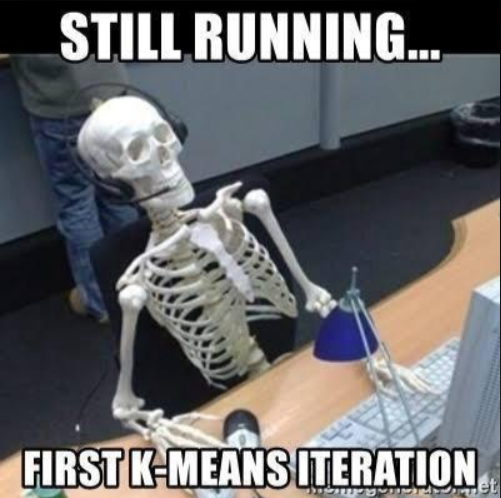